# Wordnet (słowosieć)

In [1]:
import requests
import json
import itertools
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import queue
import math

In [2]:
def request(params):
    url = 'http://api.slowosiec.clarin-pl.eu/plwordnet-api/' + params
    result = requests.get(url)
    return json.loads(result.text)

In [3]:
def req_meanings(word):
    meanings = request(f'senses/search?lemma={word}')['content']
    meanings = [(meaning['id'], meaning['domain']['description']) for meaning in meanings]
    return meanings

In [4]:
def req_synonyms(word):
    meanings_ids = [meaning_id for  (meaning_id, meaning_desciption) in req_meanings(word)]
    synsets_ids = [request(f'senses/{meaning_id}/synset')['id'] for meaning_id in meanings_ids]
    synsets_meanings = [request(f'synsets/{synset_id}/senses') for synset_id in synsets_ids]
    synonyms = set()
    for synset_meanings in synsets_meanings:
        for meaning in synset_meanings:
            synonym = meaning['lemma']
            synonyms.add((synonym['id'], synonym['word']))
    return synonyms

In [5]:
def find_relation(start_node, synsets, nodes_found, relation, max_depth=100):
    nodes = []
    nodes.append([start_node, synsets])
    for synset_id in synsets:
        synsets_to = request(f'synsets/{synset_id}/relations/from')
        synsets_to = [synset_to['synsetTo']['id'] 
                      for synset_to in synsets_to 
                      if synset_to['relation']['name'] == relation]
        nodes.append([synset_id, synsets_to])
    
        nodes_candidates = [syn_id for syn_id in synsets_to if syn_id not in nodes_found]
        nodes_found.update(nodes_candidates)
        if len(nodes_candidates) > 0 and max_depth > 0:
            nodes += find_relation(synset_id, nodes_candidates, nodes_found, relation, max_depth-1)
    return nodes

In [6]:
def relation_graph(word, relation, max_depth=100):
    meanings = req_meanings(word)
    first_meaning_id = meanings[0][0]
    synset = [request(f'senses/{first_meaning_id}/synset')['id']]
    nodes = find_relation(synset[0], synset, set(synset), relation, max_depth)
    nodes_ids = set(itertools.chain.from_iterable([[node_id]+sysnets_to_ids for node_id, sysnets_to_ids in nodes]))
    
    nodes_meanings = dict()
    for node_id in nodes_ids:
        meanings = [meaning['lemma']['word'] for meaning in request(f'synsets/{node_id}/senses')]
        meanings = ',\n'.join(map(str, meanings))
        nodes_meanings[node_id] = meanings
        
    edges = []
    for from_node, rels in nodes:
        for to_node in rels:
            if (from_node, to_node) not in edges and from_node != to_node:
                edges.append((from_node, to_node))
    edges = [(nodes_meanings[r1], nodes_meanings[r2]) for (r1,r2) in edges]
        
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    plt.figure(figsize=(12, 8))
    pos = graphviz_layout(graph)
    nx.draw(graph,pos,labels={node:node for node in graph.nodes()})

In [7]:
def group_relation_graph(group):
    
    edge_labels = {}
    node_labels = {}
    edges = []
    
    for word, meaning_number in group:
        meanings = req_meanings(word)
        if len(meanings) > (meaning_number-1):
            meaning = meanings[meaning_number-1]
            synset_id = request(f'senses/{meaning[0]}/synset')['id']
            synset_from_meanings = [meaning['lemma']['word'] for meaning in request(f'synsets/{synset_id}/senses')]
            synset_from_meanings = ',\n'.join(map(str, synset_from_meanings))
            node_labels[synset_id] = synset_from_meanings
            node_labels[meaning[0]] = word+str(meaning_number)
            edge = (meaning[0], synset_id)
            edges.append(edge)
            edge_labels[edge] = 'synset'
            
            for relation in request(f'synsets/{synset_id}/relations/from'):
                synsetTo_id = relation['synsetTo']['id']
                synsetTo_meanings = [meaning['lemma']['word'] for meaning in request(f'synsets/{synsetTo_id}/senses')]
                synsetTo_meanings = ',\n'.join(map(str, synsetTo_meanings))
                edge = (synset_id, synsetTo_id)
                relation_type = relation['relation']['name']
                edges.append(edge)
                edge_labels[edge] = relation_type
                node_labels[synsetTo_id] = synsetTo_meanings
                
    graph = nx.DiGraph()
    graph.add_edges_from(edges)

    plt.figure(figsize=(15, 15))
    pos = graphviz_layout(graph)
    nx.draw(graph,pos)
    nx.draw_networkx_edge_labels(graph,pos,edge_labels=edge_labels)
    nx.draw_networkx_labels(graph, pos, node_labels)

### Find all meanings of the szkoda noun and display all their synonyms.

In [8]:
req_meanings('szkoda')

[(8769, 'plWN miejsca i umiejscowienie'),
 (8770, 'plWN czasowniki wyrażające uczucia'),
 (8771, 'plWN posiadanie i jego zmiana')]

In [9]:
req_synonyms('szkoda')

{(243080, 'strata'),
 (249489, 'szkoda'),
 (270658, 'uszczerbek'),
 (270916, 'utrata'),
 (300080, 'żal'),
 (300109, 'żałować')}

### Find closure of hypernymy relation for the first meaning of the wypadek drogowy expression. Create diagram of the relations as a directed graph.

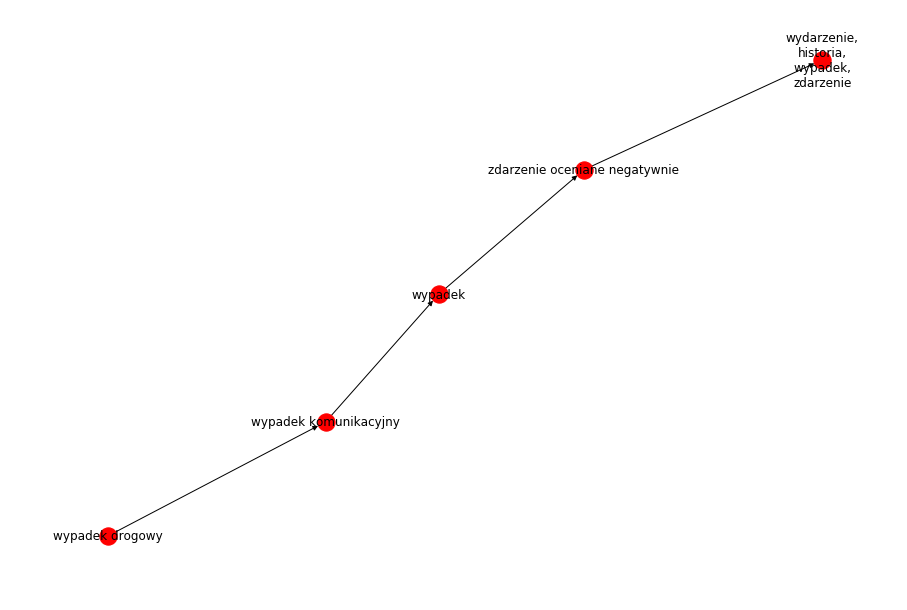

In [10]:
relation_graph('wypadek drogowy', 'hiponimia')

### Find direct hyponyms of wypadek1 noun.

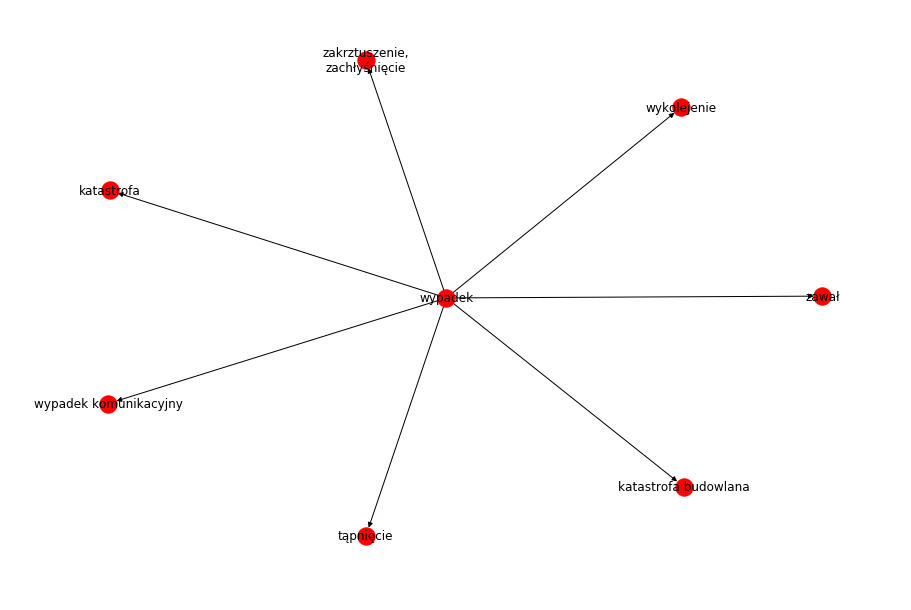

In [11]:
relation_graph('wypadek', 'hiperonimia', max_depth=0)

### Find second-order hyponyms of the same noun.

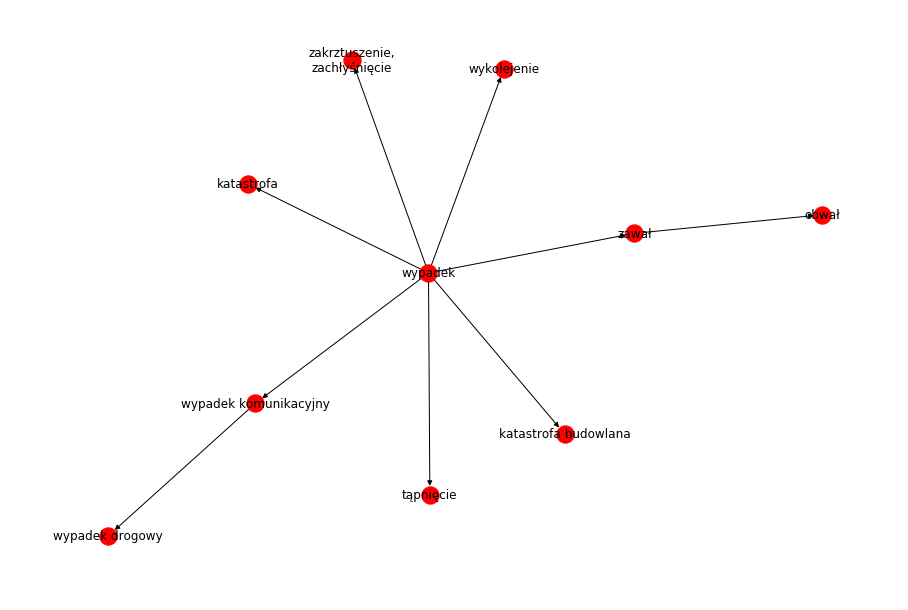

In [12]:
relation_graph('wypadek', 'hiperonimia', max_depth=1)

### Display as a directed graph (with labels for the edges) semantic relations between the following groups of lexemes:
1. szkoda2, strata1, uszczerbek1, szkoda majątkowa1, uszczerbek na zdrowiu1, krzywda1, niesprawiedliwość1, nieszczęście2.
2. wypadek1, wypadek komunikacyjny1, kolizja2, zderzenie2, kolizja drogowa1, bezkolizyjny2, katastrofa budowlana1, wypadek drogowy1.

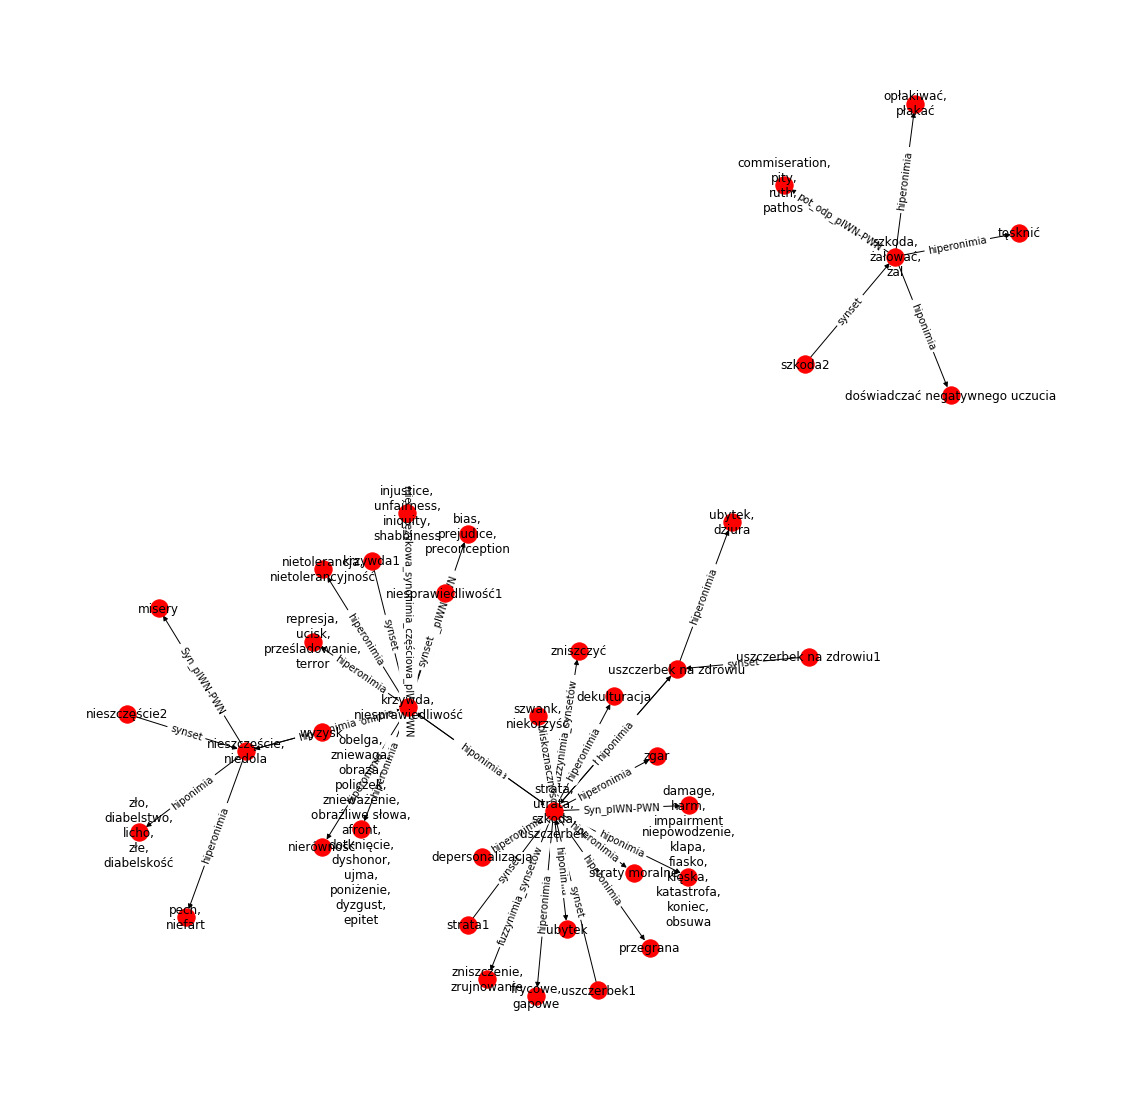

In [13]:
group_relation_graph([('szkoda',2),('strata',1),('uszczerbek',1),('szkoda majątkowa',1),
                     ('uszczerbek na zdrowiu',1),('krzywda',1),('niesprawiedliwość',1),('nieszczęście',2)])

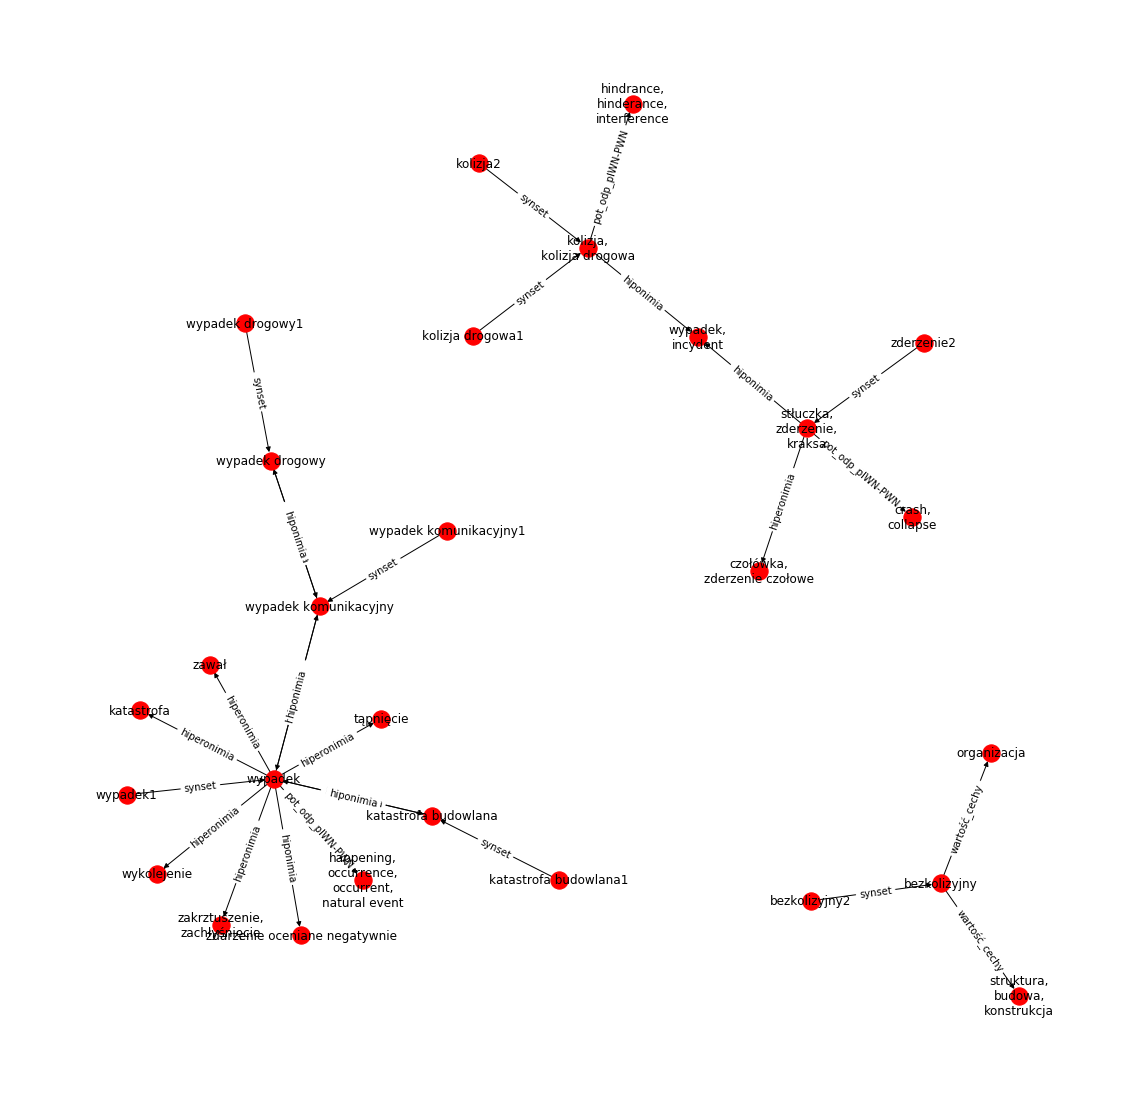

In [14]:
group_relation_graph([('wypadek',1),('wypadek komunikacyjny',1),('kolizja',2),('zderzenie',2),
                     ('kolizja drogowa',1),('bezkolizyjny',2),('katastrofa budowlana',1),('wypadek drogowy',1)])

### Find the value of Leacock-Chodorow semantic similarity measure between following pairs of lexemes:
1. szkoda2 - wypadek1,
2. kolizja2 - szkoda majątkowa1,
3. nieszczęście2 - katastrofa budowlana1.

In [15]:
lexem_pairs = [(('szkoda',2),('wypadek',1)), (('kolizja',2),('szkoda majątkowa',1)), 
               (('nieszczęście',2),('katastrofa budowlana',1))]

In [52]:
def LCH_similarity(path, depth):
    return -math.log(path/(depth*2.))

def find_shortest_path(lexem1, lexem2, max_depth=50):
    word1, meaning_number1 = lexem1
    word2, meaning_number2 = lexem2
    
    meaning1 = req_meanings(word1)
    if len(meaning1) > meaning_number1-1:
        meaning1 = meaning1[meaning_number1-1]
        synset1_id = request(f'senses/{meaning1[0]}/synset')['id']
    else:
        print('No meaning of the given number for lexem 1')
        return -1
    
    meaning2 = req_meanings(word2)
    if len(meaning2) > meaning_number2-1:
        meaning2 = meaning2[meaning_number2-1]
        synset2_id = request(f'senses/{meaning2[0]}/synset')['id']
    else:
        print('No meaning of the given number for lexem 2')
        return -1
    
    start_node = synset1_id
    end_node = synset2_id
    explored = set()
    q = queue.PriorityQueue()
    q.put((0,start_node))
    
    if start_node == end_node:
        return 0
        
    while not q.empty():
        distance, node = q.get()
        
        if node not in explored: 
            explored.add(node)
            neighbours = request(f'synsets/{node}/relations')
              
            for neighbour in neighbours:
                
                neighbour_to = neighbour['synsetTo']['id']
                                
                if neighbour_to == end_node:
                    return distance+1
                
                if distance < max_depth:
                    q.put((distance+1,neighbour_to))

    print("Path doesn't exist or is over max_depth limit") 
    return -1

def taxonomy_depth(lexem):
    
    word, meaning_number = lexem
    
    meaning = req_meanings(word)
    if len(meaning) > meaning_number-1:
        meaning = meaning[meaning_number-1]
        synset_id = request(f'senses/{meaning[0]}/synset')['id']
    else:
        print('No meaning of the given number for lexem ' + str(lexem))
        return -1
    
    start_node = synset_id
    explored = set()
    q = queue.PriorityQueue()
    q.put((0,start_node))
    max_distance = 0
    
    while not q.empty():
        distance, node = q.get()
        if distance > max_distance:
            max_distance = distance
        
        if node not in explored:
            explored.add(node)
            neighbours = request(f'synsets/{node}/relations/from')
      
            for neighbour in neighbours:
                neighbour_to = neighbour['synsetTo']['id']
                if neighbour['relation']['name'] == 'hiponimia':
                    if neighbour_to not in explored:
                        q.put((distance+1,neighbour_to))
                                        
    return max_distance

In [54]:
max_depth = 50
for pair in lexem_pairs:
    lexem1, lexem2 = pair
    path = find_shortest_path(lexem1,lexem2,max_depth)
    if path >= 0:
        print('Shortest path length: ' + str(path))
        depth_lexem1 = taxonomy_depth(lexem1)
        depth_lexem2 = taxonomy_depth(lexem2)    
        lch = LCH_similarity(path, max(depth_lexem1, depth_lexem2))
        print(lexem1, lexem2)
        print('Leacock-Chodorow similarity: ' + str(lch))
    else:
        print('Connection not found')

Shortest path length: 5
('szkoda', 2) ('wypadek', 1)
Leacock-Chodorow similarity: 0.6931471805599453
No meaning of the given number for lexem 2
Connection not found
Shortest path length: 5
('nieszczęście', 2) ('katastrofa budowlana', 1)
Leacock-Chodorow similarity: 0.6931471805599453


W przypadku drugiej pary z powodu braku znaczeń i synsetu dla wyrażenia 'szkoda majątkowa' nie ma wyników ani w grafie powyżej ani w badaniu podobieństwa. 

Przy obliczaniu głębokości taksonomii wykorzystałam tylko relacje hiponimii, ponieważ ilość połączeń była tak duża, że API Słowosieci odcinało dalsze zapytania po pewnym czasie.

### Questions/problems:
##### 1. What is the necessary step to use the knowlege from dictionaries such as WordNet?

&nbsp; Konieczne jest zrozumienie budowy takiego słownika.

##### 2. Assess the value of WordNet as a resource for representing the sense of sentences (not words in isolation).

&nbsp; W przypadku całych zdań WordNet nie sprawdziłby się, ponieważ pomimo, że każde wyrażenie/słowo ma opisane bardzo wiele swoich znaczeń, nie jesteśmy w stanie stwierdzić, o które chodziło w kwestii całego zdania. Np. "Piękny zamek na wzgórzu." w takim zdaniu wykorzystując jedynie słowosieć nie wiemy, czy chodzi o zamek błyskawiczny, czy budowlę, a w kontekście całego zdania jest to dość oczywiste.

##### 3. Discuss the problmes comming from using structured knowledge resources such as WordNet.

&nbsp; Problemem takim jest właśnie np. analiza powiązań. Pomimo, że język jest strukturalny to możliwości różnych połączeń jest ogromna ilość i na typ tego połączenia może się składać bardzo dużo czynników. W strukturze ciężko jest zamodelować np. kontekst wypowiedzi, który często jest niezbędny do prawidłowej oceny.  